# 3REQ system

Requirement analysis system.

The flow is presented in the following figure: 

<img src="flow.png" alt="drawing" width="700"/>

Summary:
1. Extract sections that contain words like "latency"
2. Find if they resemble requirements or not
3. Check if they are specific kinds of requirements (like signalling)
4. Write new requirements based on the text in these sections. 

In [1]:
# This is only for Miroslaw
import os
os.environ['HF_HOME'] = '/mnt/d/cache'

In [2]:
# Importing required libraries

# docx2python is used to extract text, images, tables, and other data from .docx files
from docx2python import docx2python

# os module provides functions for interacting with the operating system
import os

# numpy is used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np

# pandas is used for data manipulation and analysis
import pandas as pd

# TSNE from sklearn.manifold is used for dimensionality reduction
from sklearn.manifold import TSNE

# matplotlib.pyplot is used for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt

# SentenceTransformer is used for training and using transformer models for generating sentence embeddings
from sentence_transformers import SentenceTransformer

# tqdm is used to make loops show a smart progress meter
from tqdm import tqdm

# torch is the main package in PyTorch, it provides a multi-dimensional array with support for autograd operations like backward()
import torch

# AutoModelForCausalLM, AutoTokenizer, pipeline are from the transformers library by Hugging Face which provides state-of-the-art machine learning models like BERT, GPT-2, etc.
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# euclidean distance and cosine distance
from scipy.spatial import distance

# random generator for the last figure
import random

In [3]:
torch.cuda.is_available()

True

In [4]:
# suppress warnings
import warnings

warnings.filterwarnings("ignore")

## Part 1: List the documents's sections with "latency"

In the first step, we go through the documents in the folder "input_standards" and we extract which sections of these documents contain th word "latency". We store the results in a dictionary.

In [11]:
def extractLatencySections(doc):
    strSectionTitle = ""
    dictSections = {}
    listLatency = []
    skippedSections = 0

    doc_result = docx2python(doc,paragraph_styles = True, html=True)

    # we iterate over all lines
    # look for the section titles (which have the tag <h1>, <h2>, <h3>, etc.)
    # then we add the content of each section to the dictionary
    # and if there is a word "latency" somewhere in the section, we add the section title to the listLatency
    for oneLine in tqdm(doc_result.text.split('\n')):
        if "<h" in oneLine:
            strSectionTitle = oneLine
            dictSections[strSectionTitle] = []

        if strSectionTitle != "":  
            dictSections[strSectionTitle].append(oneLine)

        keywordsInLine = ["latency"]
        keywordsInSections = ["references", "introduction", "definition", "abstract", "conclusion", "acknowledgements", "appendix", "table of contents", "table of figures", "table of tables", "table of contents", "table of figures", "table of tables", "bibliography", "index", "glossary", "list of figures", "list of tables", "list of abbreviations", "list of symbols", "list of terms", "list of equations", "list of algorithms", "list of acronyms", "list of illustrations", "list of appendices"]

        if any(word in oneLine.lower() for word in keywordsInLine) and not any(word in strSectionTitle.lower() for word in keywordsInSections): 
            listLatency.append(strSectionTitle)
        else:
            skippedSections += 1
            
            
    # remove the keys from the dictionary if they are not part of the listLatency
    # as we want to get only the relevant sections, i.e., the one with the word latency
    for key in list(dictSections.keys()):
        if key not in listLatency:
            del dictSections[key]

    # print("Skipped sections: ", skippedSections)

    # return the dictionary with the relevant sections
    return dictSections


In [12]:
docInputFolder = "./22_standards"

# this is the return list of all the lines in the document
lstAllLines = []

# for each .docx file in the input folder
# extract the sections with latency using the extractLatencySections function
# and print the sections
for doc in tqdm(os.listdir(docInputFolder)):    

    if doc.endswith(".docx"):
        #print(f"Processing {doc}")

        # since things can go wrong with the latency library, 
        # we use a try except block to avoid the program to stop
        try: 
            dictSections = extractLatencySections(os.path.join(docInputFolder, doc))
        
            # we list the content
            # as a long list of sections 
            for key in dictSections:

                lstOneLine = [key, doc]

                for line in dictSections[key]:
                    lstOneLine.append(line)
                    
                lstAllLines.append(lstOneLine)

        except Exception as e:
            print(f"Error with {doc}: {e}")

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:23<00:00,  1.25s/it]


In [14]:
# choose the right model
# in order of size -- the last one is only for A6000 :) 

# model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("sentence-t5-large")
#model = SentenceTransformer("sentence-transformers/gtr-t5-xxl")

# list with all embeddings for the sections
lstEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstAllLines):

    # the content of the section starts on the third position of the list
    sentences = oneLine[3:]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embeddings = embeddings.mean(axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), avg_embeddings]

    lstEmbeddings.append(lstOneLine)

    iCounter += 1
    # the code below is for debug only
    # in case we want to stop the loop after a certain number of iterations
    #if iCounter == 100:
    #    break

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

100%|██████████| 222/222 [02:48<00:00,  1.32it/s]


In [15]:
# save the lstEmbeddings to an xlsx file topic_relevant.xlsx
df = pd.DataFrame(lstEmbeddings, columns=["Section", "Document", "Category", "Sentences", "Embeddings"])
df.to_excel("topic_relevant.xlsx", index=False)

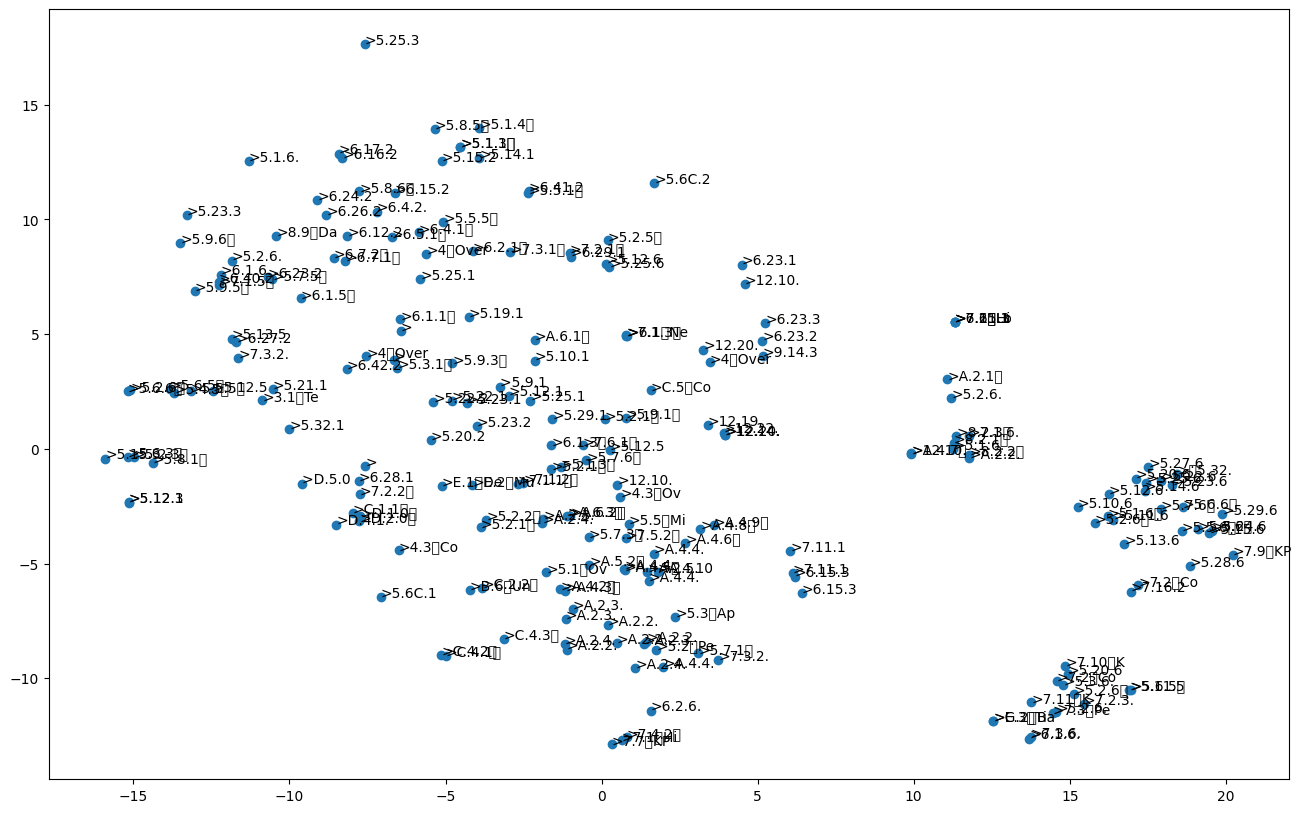

In [16]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[4] for x in lstEmbeddings])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=12, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1])

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddings]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[3:10])


plt.show()

## Part 2: Requirements classes

Checking whether these are signalling, payload, etc. requirements 

In [17]:
# read the requirements from the excel file requirements.xlsx, worksheet LR
df = pd.read_excel("req_classes.xlsx", sheet_name="LR")

# convert to list
lstRequirements = df.values.tolist()
lstRequirements[0]

# now we calculate the embeddings for each of these requirements
lstEmbeddingsReq = []

for oneLine in tqdm(lstRequirements):
    
        # the content of the section starts on the third position of the list
        sentences = oneLine[1]
    
        # Sentences are encoded by calling model.encode()
        embeddings = model.encode(sentences)
        
        # Print the average embeddings for all the sentences 
        # in this section
        avg_embedding = embeddings
        
        lstOneLine = [oneLine[0], 'latency', oneLine[1], oneLine[1], avg_embedding]
    
        lstEmbeddingsReq.append(lstOneLine)

100%|██████████| 16/16 [00:00<00:00, 17.42it/s]


In [19]:
# now we calculate the euclidean distance between the requirements and the sections
# that are relevant
lstDist = []
lstRelevantDist = []

for oneLine in tqdm(lstEmbeddings):
    for oneLineReq in lstEmbeddingsReq:
        # euclidean distance between the two embeddings
        dist = distance.cosine(oneLine[4], oneLineReq[4])
        lstDist.append([oneLine[0], oneLine[1], oneLineReq[0], dist, oneLine[3]])

# now we sort the list by the distance
lstDist.sort(key=lambda x: x[2])

# and we print them
for i in range(len(lstDist)):
    # print(f"Section {lstDist[i][0]} is close to requirement {lstDist[i][2]} with distance {lstDist[i][3]:.2f}")
    # add this to a list
    lstRelevantDist.append([lstDist[i][0], lstDist[i][1], lstDist[i][2], lstDist[i][3], lstDist[i][4]])

100%|██████████| 222/222 [00:00<00:00, 5410.46it/s]


In [20]:
# save the list to an Excel file
dfOutput = pd.DataFrame(lstRelevantDist, columns=["Section", "Document", "Requirement", "Distance", "Content"])

# sort it by section and document
dfOutput = dfOutput.sort_values(by=["Section", "Document"])

# average the distance in dfOutput per section, document and requirement
dfOutput["Distance"] = dfOutput["Distance"].astype(float)
dfGrouped = dfOutput.groupby(["Section", "Document", "Requirement", "Content"])

#convert dfGrouped to a dataframe
dfGrouped = dfGrouped.agg({"Distance": "mean"}).reset_index()

In [21]:
# now check the minimum distance per section and document
dfGrouped = dfGrouped.sort_values(by=["Section", "Document", "Distance"])

dfGrouped = dfGrouped.groupby(["Section", "Document"]).first().reset_index()

In [22]:
# now we turn this into a list of lists
lstRelevantDistGroup = dfGrouped.values.tolist()

print(len(lstRelevantDistGroup))

222


In [23]:
# convert to dataframe and save to excel lstRelevantDist
dfRelevantDist = pd.DataFrame(lstRelevantDistGroup, columns=["Section", "Document", "Requirement", "Content", "Distance"])

dfRelevantDist.to_excel("./classified_requirements.xlsx", index=False)

## Part 3: Check if the requirements exist in the database

In this step, we check if the text that we identified so far is covered by the requirements that exist in the database. We use the sentence transformers to get the embeddings of the text and then we compare them to the existin sections. 

In [24]:
thresholdPartial = 0.15
thresholdCovered = 0.20

In [25]:
# read the requirements from the Excel file
dfRelevantSections = pd.read_excel("./classified_requirements.xlsx")

lstRelevantSections = dfRelevantSections.values.tolist()

In [26]:
lstRelevantSections[0]

['<h1>',
 '22104-j00.docx',
 'LR2_payload',
 "['1\\tScope</h1>', '', 'The present document provides Stage 1 normative service requirements for 5G systems, in particular service requirements for cyber-physical control applications in vertical domains and requirements for auxiliary applications. In the context of the present document, cyber-physical systems are to be understood as systems that include engineered, interacting networks of physical and computational components; control applications are to be understood as applications that control physical processes. Examples for auxiliary applications are distributed sensing and asset monitoring.', '', 'Communication services supporting cyber-physical control applications need to be ultra-reliable and, in some cases, the end-to-end latency must be very low. Communication for cyber-physical control applications supports operation in various vertical domains, for instance industrial automation, Smart Grid . ', '', 'The aspects addressed in t

In [27]:
# model = SentenceTransformer("sentence-t5-large")
# model = SentenceTransformer("sentence-transformers/gtr-t5-xxl")

# list with all embeddings for the sections
lstRelevantEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstRelevantSections):

    # the content of the section starts on the third position of the list
    sentences = oneLine[3]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    # avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), embeddings]

    lstRelevantEmbeddings.append(lstOneLine)

    iCounter += 1

100%|██████████| 222/222 [00:14<00:00, 15.38it/s]


In [28]:
# now, read the requirements from the requirements database, file 20_requirements.xlsx
dfTRequirements = pd.read_excel("existing_requirements.xlsx")

# convert to list
lstTRequirements = dfTRequirements.values.tolist()

In [29]:
lstTRequirements[0]

['Req_1',
 'Regarding support for infrastructure protection of electrical transmission, the 5G system shall support an end-to-end latency of less than 5 ms or 10 ms, as requested by the UE initiating the communication. ',
 'NOTE 1: This requirement relates to TS 22.104, chapter 5.6C Support for infrastructure protection of electrical transmission.\nNOTE 2: Whether the end-to-end latency is 5 ms or 10 ms depends on the applied voltage level. \nNOTE 3: The end-to-end latency is between two UEs, including two wireless links.',
 'Payload',
 nan]

In [30]:
# make the embeddings
# model = SentenceTransformer("sentence-t5-large")

# list with all embeddings for the sections
lstTRequirementsEmbeddings = []
iCounter = 0

for oneLine in tqdm(lstTRequirements):

    # the content of the section starts on the requirement text
    sentences = oneLine[1]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    #avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), embeddings]

    lstTRequirementsEmbeddings.append(lstOneLine)

    iCounter += 1

100%|██████████| 20/20 [00:00<00:00, 21.23it/s]


In [31]:
# average the embeddings for all the lstTRequirementsEmbeddings
lstTRequirementsEmbeddingsNP = np.array([x[4] for x in lstTRequirementsEmbeddings])

tRequirementsAvgEmbeddings = np.mean(lstTRequirementsEmbeddingsNP, axis=0)

In [32]:
# now, calculate the average distance of all the relevant sections to the average requirements
lstDist = []

for oneLine in tqdm(lstRelevantEmbeddings):
    # euclidean distance between the two embeddings
    dist = distance.cosine(oneLine[4], tRequirementsAvgEmbeddings)
    lstDist.append([oneLine[0], oneLine[1], dist, oneLine[3]])

# now we sort the list by the distance
lstDist.sort(key=lambda x: x[3])
    

100%|██████████| 222/222 [00:00<00:00, 43882.16it/s]


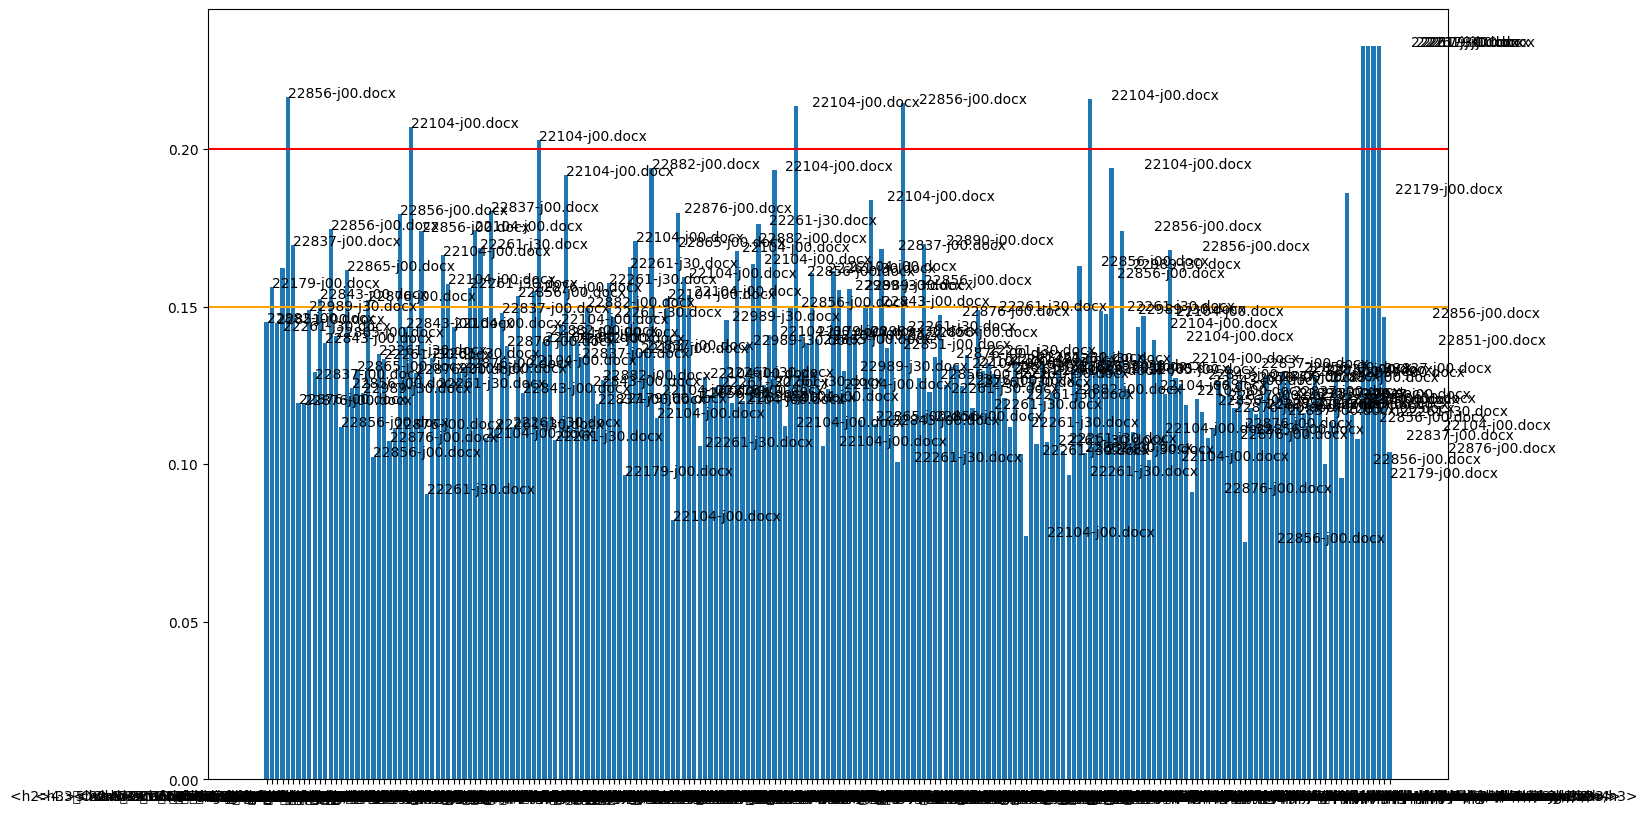

In [33]:
# create a bar plot for the distances lstDist[2]
plt.figure(figsize=(16,10))

# Create a bar plot
plt.bar([x[0] for x in lstDist], [x[2] for x in lstDist])

# Add labels to each dot
for i, label in enumerate([x[1] for x in lstDist]):
    plt.text(i, lstDist[i][2], label)

# add horizontal lines for the thresholds
plt.axhline(y=thresholdPartial, color='orange', linestyle='-')
plt.axhline(y=thresholdCovered, color='red', linestyle='-')

plt.show()

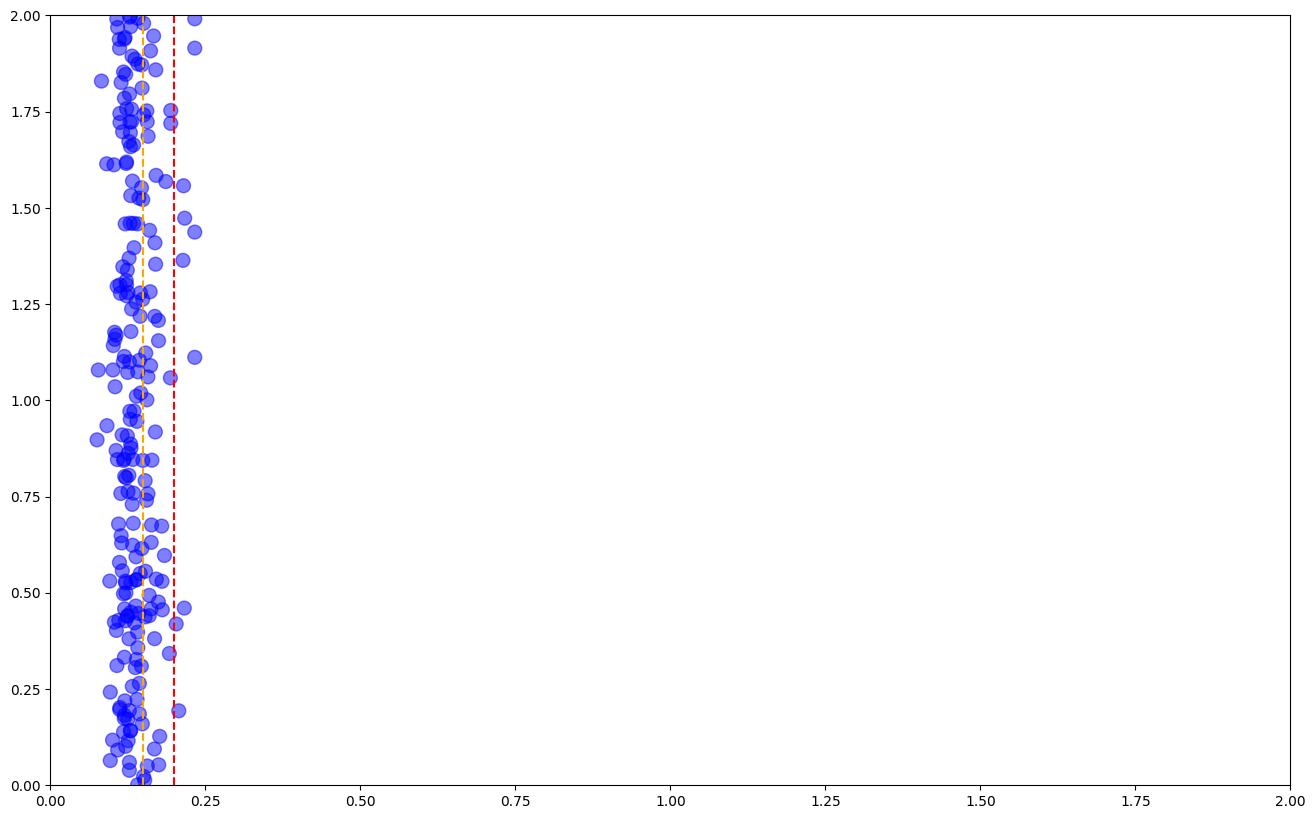

In [34]:
# Visualize the results using the scatter plot, where
# the x-axis is the distance to the average requirement
# the y-axis is always 1
# the color is red for the requirements

# Create a color map based on x[2]
color_map = {0: 'blue', 1: 'green', 2: 'red'}
colors = [color_map[0] for x in lstDist]

# we plot the t-SNE results
plt.figure(figsize=(16,10))

random.seed(42)

plt.scatter([x[2] for x in lstDist], [random.random() * 2 for x in lstDist], c=colors, s=100, alpha=0.5)

# Add labels to each dot
#for i, label in enumerate([x[3] for x in lstDist]):
#    plt.text([x[2] for x in lstDist][i], 1, label[:20]+'...', rotation='vertical')

# Add vertical lines at 0.33 and 1.0
plt.axvline(x=thresholdPartial, color='orange', linestyle='--')
plt.axvline(x=thresholdCovered, color='red', linestyle='--')

# Set the limits of the x-axis
plt.xlim(0, 2)
plt.ylim(0, 2)

plt.show()

In [35]:
# now we separate them into three lists:
# - with distance below 0.33 -- these requirements are covered
# - with distance between 0.33 and 1.0 -- these requirements are partially covered
# - with distance above 1.0 -- these requirements are not covered

lstCovered = []
lstPartiallyCovered = []
lstNotCovered = []

for oneLine in lstDist:
    if oneLine[2] < thresholdPartial:
        lstCovered.append(oneLine)
    elif oneLine[2] < thresholdCovered:
        lstPartiallyCovered.append(oneLine)
    else:
        lstNotCovered.append(oneLine)

## Part 4: create requirements based on each of these sections

In the last step, we create new requirements based on the sections identified in the previous steps.

In [36]:
torch.random.manual_seed(0)

modelInstr = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizerInstr = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

config.json:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

In [28]:
def createRequirement(content, type, model, tokenizer):
    content1 = content.split(",")
    content1 = [x for x in content1[1:] if x not in ['', " ''", " '']"]]
    content_str = " ".join(content1)
    
    strContent = f"Based on this : {content_str}. Write the requirement in the following format 'The system shall ' "
    
    messages = [
        {"role": "user", "content": strContent},
    ]

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }

    output = pipe(messages, **generation_args)
    
    return output[0]['generated_text']

In [29]:
lstGenerated = []
iCounter = 0

# we generate new requirements for the partially covered ones
if len(lstPartiallyCovered) > 0:
    for oneLine in tqdm(lstPartiallyCovered):
        if (len(oneLine[3]) < 4095):
            strRequirement = createRequirement(oneLine[3], oneLine[2], modelInstr, tokenizerInstr)
            lstGenerated.append([oneLine[0], oneLine[1], oneLine[2], oneLine[3], strRequirement])

100%|██████████| 10/10 [01:58<00:00, 11.81s/it]


In [67]:
dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Content", "Distance", "Generated requirement"])
dfOutput.to_excel("./output_partially_covered_generated.xlsx", index=False)

In [68]:
lstGenerated = []
iCounter = 0

# we generate new requirements for the not covered requirements
if len(lstNotCovered) > 0:
    for oneLine in tqdm(lstNotCovered):
        iCounter += 1
        if (len(oneLine[3]) < 10000):
            strRequirement = createRequirement(oneLine[3], oneLine[2], modelInstr, tokenizerInstr)
            lstGenerated.append([oneLine[0], oneLine[1], oneLine[2], oneLine[3], strRequirement])

100%|██████████| 2/2 [00:23<00:00, 11.77s/it]


In [69]:
dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Content", "Distance", "Generated requirements"])
dfOutput.to_excel("./output_not_covered_generated.xlsx", index=False)

In [70]:
lstGenerated = []
iCounter = 0

# we generate new requirements for the not covered requirements
if len(lstCovered) > 0:
    for oneLine in tqdm(lstCovered):
        iCounter += 1
        if (len(oneLine[3]) < 10000):
            strRequirement = createRequirement(oneLine[3], oneLine[2], modelInstr, tokenizerInstr)
            lstGenerated.append([oneLine[0], oneLine[1], oneLine[2], oneLine[3], strRequirement])

100%|██████████| 64/64 [19:28<00:00, 18.26s/it]


In [72]:
dfOutput = pd.DataFrame(lstGenerated, columns=["Section", "Document", "Content", "Distance", "Generated requirements"])
dfOutput.to_excel("./output_covered_generated.xlsx", index=False)